In [1]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

     |████████████████████████████████| 138 kB 9.4 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f1e674f283802b037e612f4183cb85290e2ed024b1d83407230145c7cbb93d2e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.8 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is i

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [2]:
! signate list 
! signate files --competition-id=406
! signate download --competition-id=406

  competitionId  title                                                                                      closing     prize                  submitters
---------------  -----------------------------------------------------------------------------------------  ----------  -------------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                                       -                                        5395
             24  【練習問題】お弁当の需要予測                                                               -                                        6663
             27  【練習問題】Jリーグの観客動員数予測                                                        -                                        1527
            100  【練習問題】手書き文字認識                                                                 -           Knowledge                     204
            102  【練習問題】タイタニックの生存予測                                                         -           Knowledge                    1259
 

In [3]:
! unzip train_data.zip

Archive:  train_data.zip
   creating: train_data/
  inflating: train_data/cast_def_0_335.jpeg  
   creating: __MACOSX/
   creating: __MACOSX/train_data/
  inflating: __MACOSX/train_data/._cast_def_0_335.jpeg  
  inflating: train_data/cast_ok_0_369.jpeg  
  inflating: __MACOSX/train_data/._cast_ok_0_369.jpeg  
  inflating: train_data/cast_ok_0_294.jpeg  
  inflating: __MACOSX/train_data/._cast_ok_0_294.jpeg  
  inflating: train_data/cast_ok_0_152.jpeg  
  inflating: __MACOSX/train_data/._cast_ok_0_152.jpeg  
  inflating: train_data/cast_def_0_323.jpeg  
  inflating: __MACOSX/train_data/._cast_def_0_323.jpeg  
  inflating: train_data/cast_def_0_2378.jpeg  
  inflating: __MACOSX/train_data/._cast_def_0_2378.jpeg  
  inflating: train_data/cast_ok_0_345.jpeg  
  inflating: __MACOSX/train_data/._cast_ok_0_345.jpeg  
  inflating: train_data/cast_def_0_2401.jpeg  
  inflating: __MACOSX/train_data/._cast_def_0_2401.jpeg  
  inflating: train_data/cast_def_0_61.jpeg  
  inflating: __MACOSX/train_

In [4]:
# ディレクトリ内のデータの確認
%ls

adc.json   sample_data/           test_data.zip  train_data/
__MACOSX/  sample_submission.csv  train.csv      train_data.zip


In [5]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


デバイス：cuda
                    id  target
0  cast_def_0_335.jpeg       0
1  cast_def_0_323.jpeg       0
2   cast_def_0_61.jpeg       0
3  cast_def_0_163.jpeg       0
4  cast_def_0_175.jpeg       0
MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_st

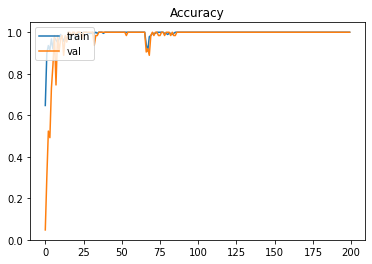

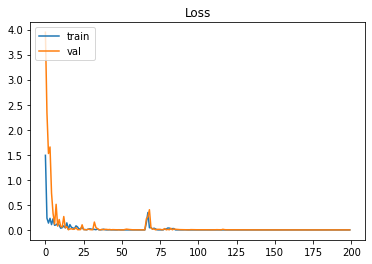

In [8]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch import nn, optim

from collections import defaultdict

'''
定数の指定
'''

# 学習データのラベルマスター
train_master_path = './train.csv'

# 画像データのディレクトリ
img_dir = './train_data/' # 画像データのディレクトリ

# リサイズする画像サイズ
photo_size = 300

# バッチサイズ
batch_size = 4

# クラス数の定義
num_classes = 2

# 学習率
lr = 0.0001

# 学習済み
pretrained = True

# エポック数
epochs = 200

# 保存先のパス
save_path = '/content/drive/My Drive/Colab Notebooks/SIGNATE/casting_pytorch/model/casting_pytorch_Epoch'

# 学習に使用する機器(device)の設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'デバイス：{device}')

'''
データの読み込み
'''

# ラベルデータの読み込み
train_master = pd.read_csv(train_master_path, sep=',')
print(train_master.head())

# 画像データの名前リストの抽出
image_name_list = train_master['id'].values

# ラベルリストの抽出
label_list = train_master['target'].values

'''
前処理とデータセットの作成
'''

# 学習データと検証データに分割
x_train, x_val, y_train, y_val = train_test_split(image_name_list, label_list, test_size=0.25, stratify=label_list, random_state=42)

# transformの設定
transform = {
    'train': transforms.Compose([
        transforms.Resize(photo_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    'val': transforms.Compose([
        transforms.Resize(photo_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
}

# Datasetの設定
class CastingDataset(Dataset):
    def __init__(self, image_name_list, label_list, img_dir, phase=None):
        self.image_name_list = image_name_list # 画像ファイル名
        self.label_list = label_list # ラベル
        self.img_dir = img_dir # 画像データのディレクトリ
        self.phase = phase # 変数phaseで学習(train)もしくは検証(val)の設定を行う
        self.transform = transform

    def __len__(self):
        return len(self.image_name_list) # 1エポックあたりに読み込むデータ数として、入力データの数を指定

    def __getitem__(self, index):
        
        # index番目の画像を読み込み、前処理を行う
        image_path = os.path.join(self.img_dir, self.image_name_list[index]) # train_master.iloc[index, 0]はファイル名を抽出
        img = Image.open(image_path)
        img = self.transform[self.phase](img)
        
        # index番目のラベルを取得する
        label = self.label_list[index]
        
        return img, label

# Datasetのインスタンス作成
train_dataset = CastingDataset(x_train, y_train, img_dir, phase='train')
val_dataset = CastingDataset(x_val, y_val, img_dir, phase='val')

# Dataloader
dataloader = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    }

'''
モデルの定義
'''

model = models.mobilenet_v3_large(pretrained=pretrained)
fc_in_features = model.classifier[3].out_features # 最終レイヤー関数の次元数
model.fc = nn.Linear(fc_in_features, num_classes) # 最終レイヤー関数の付け替え
print(model)

# モデルをGPUに送る
model.to(device)

'''
学習
'''

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

history = defaultdict(list)

# 学習モデルの定義
def train_model(model, epochs, loss_fn, optimizer):
    
    # ベストスコアの初期化
    best_loss = np.inf
    
    # エポックループの設定
    for epoch in range(epochs):
        
        # 現在のエポック数の出力
        print(f'Epoch: {epoch+1} / {epochs}')
        print('--------------------------')
        
         # 毎エポック: 学習・検証ループの設定
        for phase in ['train', 'val']:
            
            # 学習モード、検証モードの切替
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 損失値のリセット
            epoch_loss = 0.0
            # 正解数
            corrects = 0
            # 予測値リストのリセット
            pred_list = []
            # 正解値リストのリセット
            true_list = []
            
            # dataloaderから、ミニバッチ(batch_size)単位でのデータの読み込み
            for images, labels in dataloader[phase]:
                
                # 入力データ、正解ラベルをモデルと同じdeviceへ移動
                images = images.to(device)
                labels = labels.to(device)
                
                # 勾配情報の初期化
                optimizer.zero_grad()
                
                # 学習時のみ勾配情報を有効に
                with torch.set_grad_enabled(phase=='train'):
                    
                    # モデルによる計算
                    outputs = model(images)
                    # 損失値の計算
                    loss = loss_fn(outputs, labels)
                    # 予測ラベルの算出
                    preds = torch.argmax(outputs, dim=1) # 予測値を出力
                    
                    # 学習時のみ、バックプロパゲーションとパラメータ更新
                    if phase == 'train':
                        
                        # 誤差逆伝播法により勾配の算出
                        loss.backward()
                        # optimizerのパラメータ更新
                        optimizer.step()
                    
                    # 損失値の追加
                    epoch_loss += loss.item() * images.size(0)
                    
                    # 正解数の追加
                    corrects += torch.sum(preds == labels.data)                    
                    
                    # 予測ラベルの追加
                    preds = preds.to('cpu').numpy()
                    pred_list.extend(preds)
                    
                    # 正解ラベルの追加
                    labels = labels.to('cpu').numpy()
                    true_list.extend(labels)
            
            # 1エポック内における損失値の平均
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            
            # 正解率の算出
            accuracy = corrects.double() / len(dataloader[phase].dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(accuracy)
            
            # 各評価スコアの出力
            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f}')
            
            # 検証時、検証スコアとベストスコアの大小比較を行う
            if (phase == 'val') and (epoch_loss < best_loss):
                
                ## 検証スコアが改善した場合のみ以下の処理を行う
                
                # ベストスコアの更新
                best_loss = epoch_loss
                # パラメータの名前を指定
                param_name = f'{save_path}{epoch+1}_logloss_{epoch_loss:.4f}.pth'
                # パラメータの保存
                torch.save(model.state_dict(), param_name)
    
    # 正解率の推移をプロット
    plt.plot(history['train_accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # ロスの推移をプロット
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

'''
モデルの学習と推論の実行
'''

train_model(model, epochs, criterion, optimizer)